In [14]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

In [32]:
def draw_graph(adj_list, positions, axis=False, edges=True, node_size=3):
    '''
    Draws graph with given nodes and edges. 

    Args:
        adj_list (iterable) :   adjacency list (not to be confused with adjacency matrix), shape=[number of edges, 2]
                                e.g adj_list[i] = (j, k) -> i-th edge (in edges) connects node j with node k (in nodes)
        positions (iterable)    : shape=[number of nodes, 2], positions[i] = (x, y) -> x,y-positition of node i (in nodes)
    
    Optional args:
        axis (bool)             : if True, plots axis (default: False)
        node_size (float)       : size of nodes in plot (default: 3)
    
    Todo:
        Introduce colorbar for node/edge values (currently, node/edge values not supported)
    '''

    edge_coordinates = np.array([[positions[edge[0]], positions[edge[1]]] for edge in adj_list])
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot()
    ax.scatter(*positions.T, s=node_size) #.T-> shape=(2, num_nodes), *-> 2 seperate lists with num_nodes elements each
    if edges:
        for edge in edge_coordinates: #edge shape = (2, 2)
            ax.plot(*edge.T, c="dimgrey", alpha=0.5)
    #ax.set_xlim(-10, 10)
    #ax.set_ylim(-10, 10)
    if not axis:
        ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
        plt.axis('off')

In [62]:
def genLatticeNodes(len_ex, len_ey, theta, nx_max=20, ny_max=20):
    '''
    Generates Bravais-lattice (https://en.wikipedia.org/wiki/Bravais_lattice). Only computes node-positions. To obtain edges, use genAdjacencyList.

    Args:
        len_ex (float)      :   length of first unit vector 
        len_ey (float)      :   length of second unit vector
        theta (float)       :   specifies the angle between first and second unit vector
    
    Optional args:
        nx_max (int)            :   number of nodes in x-direction (direction of the first unit vector), default: 20
        ny_max (int)            :   number of nodes in y-direction (direction of the second unit vector), default: 20

    Returns:
        pos (iterable)      :   nodes positions, shape=[num_nodes, 2] 
        transform           :   transformation matrix (shape=[2, 2])                     
    '''
    #num_nodes = nx_max*ny_max
    e_x = len_ex*np.array([1, 0], dtype=float)
    e_y = len_ey*np.array([np.cos(theta), np.sin(theta)], dtype=float)
    transform = np.array([e_x, e_y]).T
    transform_inv = np.linalg.inv(transform)
    #id_diag = np.zeros(shape=(num_nodes, ), dtype=int) #(id_node, num_diag, )

    ind_pos = np.array(np.meshgrid(np.arange(0, nx_max), np.arange(0, ny_max)), dtype=int).T.reshape(-1, 2) #shape=(num_nodes, 2)
    #id_diag[:] = ind_pos[:, 0] - ind_pos[:, 1] # x-y = id_diag
    
    #positions
    pos = np.array([transform@p for p in ind_pos])

    return pos, transform, transform_inv #id_diag

In [20]:
def posMod(pos, mod_x=10, mod_y=10):
    pos[:, 0] = pos[:, 0] % mod_x
    pos[:, 1] = pos[:, 1] % mod_y
    return pos

In [77]:
def genAdjacencyList(positions, radius, transform_inv, p=2):
    '''
    Generates adjacency list of given lattice according to the following rule: If node j lies in circle with given radius around node i, then (i, j) is appended to adjancency list.
    
    Args:
        positions (iterable)    :   nodes positions, shape=[num_nodes, 2]
        radius (float)          :   radius of the circle with which neighbors are determined

    Returns:
        adj_list (iterable) :   adjacency list (shape=[num_nodes, 2]),
                                e.g adj_list[i] = (j, k) -> i-th edge (in edges) connects node j with node k (in nodes)
    '''
    pos_inv = np.array([transform_inv@p for p in positions])
    adj_list = np.empty(shape=(0, 2), dtype=int)
    num_nodes = len(pos_inv)

    for n in range(num_nodes):
        node_center_pos = pos_inv[n, :]
        dist = np.sum(np.abs((pos_inv - node_center_pos))**p, axis=1)
        dist[n] = radius + 1 #-> no edges (n,n)
        
        in_sphere_ind = np.array(np.nonzero((dist < radius**p))).reshape(-1, 1)
        edges = np.concatenate((np.full(shape=(len(in_sphere_ind), 1), fill_value=n), in_sphere_ind), axis=1)
        adj_list = np.concatenate((adj_list, edges))

    return adj_list

In [22]:
def addNoise(arr, mu, sigma, scale_x, scale_y):
    '''
    Adds normal distributed noise to array.
    
    Args:
        arr (iterable)      :   array on which values noise is added (shape=[-1, 2])
        mu (float)          :   mean value of normal distributed noise
        sigma (float)       :   standard deviation
        scale_x/y (float)   :   scaling factor   
    
    Returns:
        arr (iterable)  :   noisy positions
    '''
    
    arr[:, 0] += scale_x*np.random.normal(mu, sigma, size=len(arr))
    arr[:, 1] += scale_y*np.random.normal(mu, sigma, size=len(arr))

    return arr

In [23]:
def rotateLattice(pos, alpha):
    '''
    Rotates position by alpha degress around origin.
    
    Args:
        pos (iterable)  :   shape=[-1, 2], shape[i] = (x, y)
        alpha (float)   :   angle (in radians)
    
    Returns:
        pos_ (iterable) :   rotated positions
    '''
    e_x_rot = np.array([np.cos(alpha), np.sin(alpha)])
    e_y_rot = np.array([np.cos(alpha+np.pi/2), np.sin(alpha+np.pi/2)])
    rotMat = np.array([e_x_rot, e_y_rot], dtype=float).T
    pos_ = np.array([rotMat@p for p in pos])
    return pos_

In [24]:
def saveLattice(filename, nodes, edges, adj_list, label, positions=list()):
    '''
    Saves lattice to .npz file.
    
    Args:
        filename (string)   :   file to save to
        nodes (iterable)    :   node values
        edges (iterable)    :   edge values
        adj_list (iterable) :   adjacency list (see also draw_graph()), shape=[number of edges, 2]
        label (iterable)    :   label (can later be used for classifying the graph), shape is arbitrary
                                e.g. if the graphs should be classified in distinct categories, then label=[i] (i represents category), would be a reasonable choice 

    Optional args:
        positions (iterable)    :   nodes positions, if empty, no positions will be stored, default: empty
    '''

    if len(positions) > 0:
        if len(positions)!=len(nodes):
           print("Error: len(positions) != len(nodes)")
           return
        np.savez(filename, nodes=nodes, edges=edges, adj_list=adj_list, label=label, positions=positions)
    else:
        if len(edges)!=len(adj_list):
            print("Error: len(edges) != len(adj_list)")
            return 
        np.savez(filename, nodes=nodes, edges=edges, label=label, adj_list=adj_list)

In [25]:
def removeEdges(index_set, adj_list):
    if len(index_set) == 0:
        return adj_list
    index_set_rev = np.zeros(shape=(len(index_set), ), dtype=int)
    for i in range(len(index_set)):
        removed_edge = adj_list[index_set[i]]
        #print(removed_edge.shape)
        #print(np.nonzero(np.sum(adj_list==np.flip(removed_edge), axis=1)==2)[0])
        index_set_rev[i] = np.nonzero(np.sum(adj_list==np.flip(removed_edge), axis=1)==2)[0][0]
        
    return np.delete(adj_list, np.concatenate((index_set, index_set_rev)), axis=0)

def removeNodes(index_set, pos, adj_list):
    if len(index_set) == 0:
        return pos, adj_list
    
    pos = np.delete(pos, index_set, axis=0)

    for index in np.flip(np.sort(index_set)):
        ind_to_remove, = np.nonzero(np.sum(adj_list==index, axis=1))
        adj_list = removeEdges(ind_to_remove, adj_list)
        mask = adj_list > index
        adj_list[mask] -= 1

    return pos, adj_list

In [26]:
def countNeighbors(adj_list, node_index):
    '''
    Computes the number of nearest neighbors of one specific node. 
    Attention: If (node_index, j) is in the adjacency list, then j is regarded as a neighbor. 
    However, if (j, node_index) is in the adjacency list, then j is not regarded as a neighbor.

    Args:
        adj_list (iterable) :   adjacency list, shape=[number of nodes, 2]
        node_index (int)    :   the node index to look at
    
    Return:
        num_neighbors (int) :   number of neighbors of node with indes node_index
    '''
    num_neighbors = 0
    for edge in adj_list:
        if edge[0] == node_index:
            num_neighbors += 1
    return num_neighbors

In [27]:
def getNodeValues(num_nodes):
    return np.zeros(shape=(num_nodes, 1))

def getEdgeValues(adj_list, positions):
    values_edges = np.zeros(shape=(len(adj_list), 2))
    for e in range(len(adj_list)):
        values_edges[e, :] = positions[adj_list[e, 1]] - positions[adj_list[e, 0]]
    return values_edges

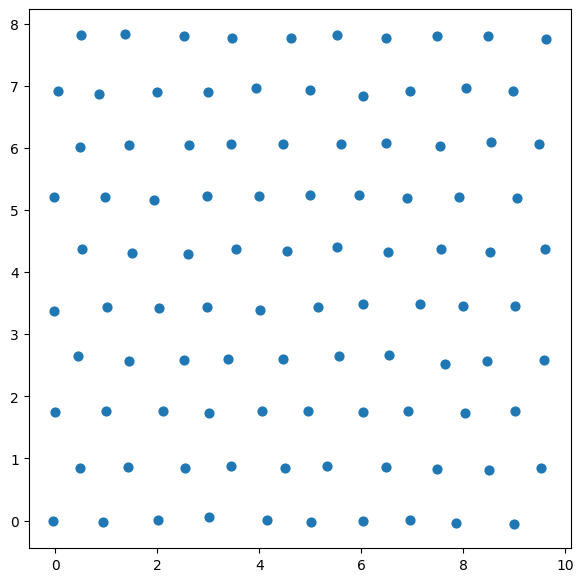

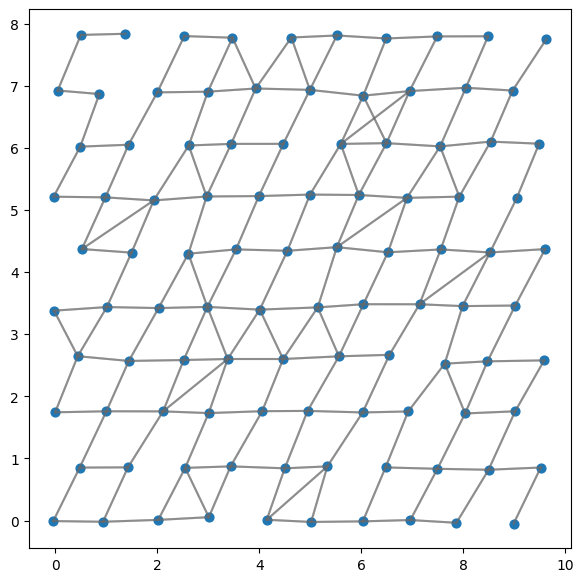

In [114]:
pos, transform, transform_inv = genLatticeNodes(1, 1, np.pi/3, nx_max=10, ny_max=10)
pos = posMod(pos, 1*10, 10)
pos = addNoise(pos, 0, 0.5, 0.07*2, 0.07*1)
adj_list_2 = genAdjacencyList(pos, 1.05 + 0.07, transform_inv, p=2)
adj_list_p = genAdjacencyList(pos, 1.05 + 0.07, transform_inv, p=4)
#pos[:, 1] *= 10*np.sin(np.pi/9)

#pos, adj_list = removeNodes([0, 1, 2, 35], pos, adj_list)
#adj_list = removeEdges([20], adj_list)

#pos = rotateLattice(pos, np.pi/9)

#node_values = np.zeros(shape=(num_nodes, ))
#edge_values = np.zeros(shape=(num_edges, ))
draw_graph(adj_list_2, pos, axis=True, edges=False, node_size=40)
draw_graph(adj_list_p, pos, axis=True, node_size=40)

In [55]:
def dropoutIndices(num_indices, dropout_rate):
    r = np.random.uniform(low=0, high=1, size=(num_indices, ))
    return np.nonzero(r < dropout_rate)[0]

In [ ]:
# generate N graphs for each lattice type 

square_settings = {
    "name" : "square",
    "equally_scaled" : True,
    "scale_off" : [0.99, 1.01],
    "theta" : [0.99*np.pi/2, 1.01*np.pi/2],
    "label" : [1, 0, 0, 0]
}
rectangular_settings = {
    "name" : "rectangular",
    "equally_scaled" : False,
    "theta" : [0.99*np.pi/2, 1.01*np.pi/2],
    "label" : [0, 1, 0, 0]
}
oblique_settings = {
    "name" : "oblique",
    "equally_scaled" : False,
    "theta" : [0.01*np.pi, 0.99*np.pi],
    "label" : [0, 0, 1, 0]
}
hexagonal_settings = {
    "name" : "hexagonal",
    "equally_scaled" : True,
    "scale_off" : [0.99, 1.01],
    "theta" : [0.99*2*np.pi/3, 1.01*2*np.pi/3],
    "label" : [0, 0, 0, 1]
}

settings = [square_settings, rectangular_settings, oblique_settings, hexagonal_settings]

N = 10000
p_norm = 3
mu = 0
sigma = 0.5
scale = 0.07
len_min = 0.1
len_max = 10
radius = 1.05
node_dropout_rate = 0.01
edge_dropout_rate = 0.01

for setting in settings:
    lattice_type = setting["name"]
    print(lattice_type)
    if not os.path.isdir(lattice_type):
        os.mkdir(lattice_type)

    hexagonal = (lattice_type == "hexagonal")
    theta = np.random.uniform(low=setting["theta"][0], high=setting["theta"][1], size=(N, ))
    rotate_deg = np.random.uniform(low=0, high=np.pi, size=(N, ))
    equally_scaled = setting["equally_scaled"]
    len_ex = np.random.uniform(low=len_min, high=len_max, size=(N, ))
    len_ey = np.random.uniform(low=len_min, high=len_max, size=(N, ))
    if equally_scaled:
        scale_off = setting["scale_off"]
        len_ey = len_ex*np.random.uniform(low=scale_off[0], high=scale_off[1], size=(N, ))

    for n in tqdm(range(N)):
        pos, transform, transform_inv = genLatticeNodes(len_ex[n], len_ey[n], theta[n], nx_max=10, ny_max=10)
        pos = posMod(pos, len_ex[n]*10, len_ey[n]*10)
        pos = addNoise(pos, mu, sigma, scale*len_ex[n], scale*len_ey[n])
        adj_list = genAdjacencyList(pos, radius + scale, transform_inv, p=p_norm)
        
        pos, adj_list = removeNodes(dropoutIndices(len(pos), node_dropout_rate), pos, adj_list)
        adj_list = removeEdges(dropoutIndices(len(adj_list), edge_dropout_rate), adj_list)
        pos = rotateLattice(pos, rotate_deg[n])
        
        values_nodes = getNodeValues(len(pos)) #shape=[num_nodes, num_node_features]
        values_edges = getEdgeValues(adj_list, pos) #shape=[num_edges, num_edge_features]

        label = np.array([setting["label"]])
        #edge cases, correct label
        if lattice_type == "rectangular" and (len_ey[n]/len_ex[n]<=square_settings["scale_off"][1]) and (len_ey[n]/len_ex[n] >= square_settings["scale_off"][0]):
            #print("rec -> squ:", len_ex[n], len_ey[n])
            label = np.array([square_settings["label"]])
        elif lattice_type == "oblique" and (theta[n] <= rectangular_settings["theta"][1]) and (theta[n] >= rectangular_settings["theta"][0]):
            if (len_ey[n]/len_ex[n]<=square_settings["scale_off"][1]) and (len_ey[n]/len_ex[n] >= square_settings["scale_off"][0]):
                #print("obl -> squ", theta[n])
                label = np.array([square_settings["label"]])
            else:
                #print("obl -> rec", theta[n])
                label = np.array([rectangular_settings["label"]])
        saveLattice(f"Data2d/{lattice_type}/{lattice_type}_{n}.npz", values_nodes, values_edges, adj_list, label, pos)   

print("Done")

square


100%|██████████| 10000/10000 [01:18<00:00, 127.31it/s]


rectangular


100%|██████████| 10000/10000 [01:31<00:00, 109.46it/s]


oblique


100%|██████████| 10000/10000 [01:00<00:00, 164.15it/s]


hexagonal


100%|██████████| 10000/10000 [00:56<00:00, 177.88it/s]

Done


KeysView(NpzFile 'hexagonal/hexagonal_150.npz' with keys: nodes, edges, adj_list, label, positions)
label:  [[0 0 0 1]]


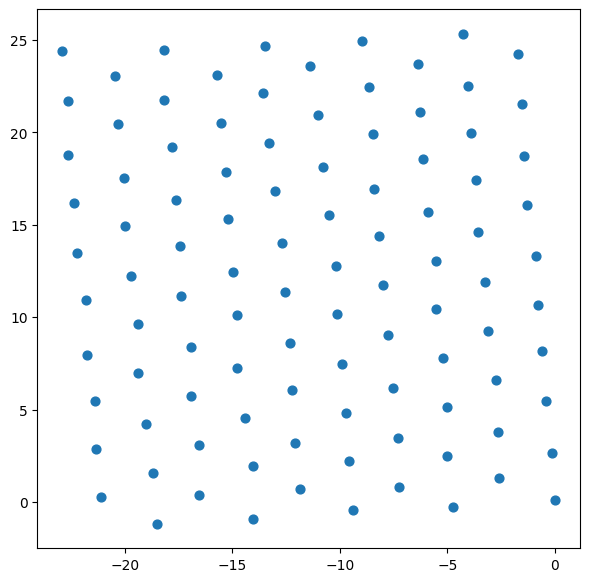

In [108]:
# quick check that generation works
graph = np.load("hexagonal/hexagonal_150.npz")
print(graph.keys())
print("label: ", graph["label"])
node_values = graph["nodes"]
edge_values = graph["edges"]
adj_list = graph["adj_list"]
pos = graph["positions"]
draw_graph(adj_list, pos, axis=True, edges=False, node_size=40)